# **TP04 - Análisis de Discriminante y Vecinos más cercanos**

## **Exploración de datos

In [66]:
#librerias
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from collections import Counter

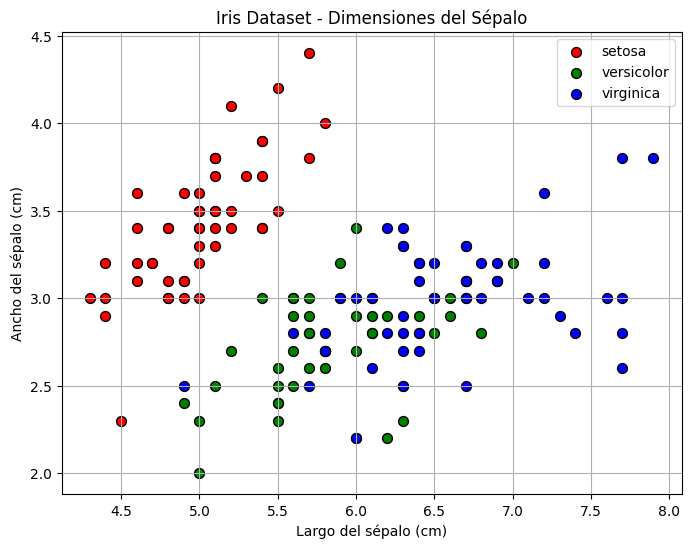

In [67]:
# Cargar la base de datos Iris
iris = datasets.load_iris()
X = iris.data[:, :2]  # Usar solo las dos primeras columnas: largo y ancho del sépalo
y = iris.target       # Las etiquetas de especie

# Dividir en entrenamiento y testeo (70% entrenamiento, 30% testeo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Graficar los datos
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
labels = iris.target_names

for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', s=50)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('Iris Dataset - Dimensiones del Sépalo')
plt.legend()
plt.grid(True)
plt.show()

## **Clasificación LDA**

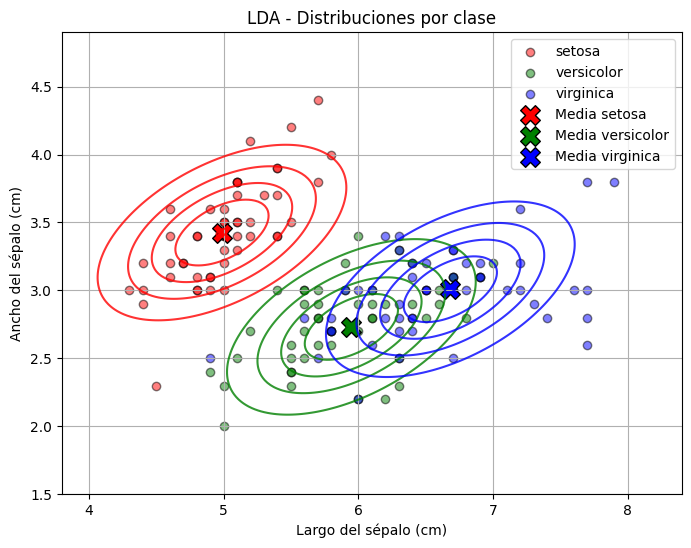

In [68]:
# ===== Clase común para LDA y QDA =====
class GaussianDiscriminantAnalysis:
    def __init__(self, mode='lda'):
        assert mode in ['lda', 'qda'], "mode debe ser 'lda' o 'qda'"
        self.mode = mode
        self.means_ = None
        self.covs_ = None
        self.priors_ = None
        self.classes_ = None
        self.shared_cov_ = None
        self.inv_shared_cov_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.means_ = []
        self.covs_ = []
        self.priors_ = []

        for cls in self.classes_:
            X_cls = X[y == cls]
            mean = X_cls.mean(axis=0)
            cov = np.cov(X_cls.T)
            self.means_.append(mean)
            self.covs_.append(cov)
            self.priors_.append(len(X_cls) / len(X))

        self.means_ = np.array(self.means_)
        self.covs_ = np.array(self.covs_)
        self.priors_ = np.array(self.priors_)

        if self.mode == 'lda':
            # calcular covarianza común (promedio ponderado)
            pooled_cov = np.zeros((n_features, n_features))
            for i, cls in enumerate(self.classes_):
                X_cls = X[y == cls]
                pooled_cov += (X_cls.shape[0] - 1) * self.covs_[i]
            self.shared_cov_ = pooled_cov / (len(X) - len(self.classes_))
            self.inv_shared_cov_ = np.linalg.inv(self.shared_cov_)

    def predict_proba(self, X):
        probs = []
        for x in X:
            scores = []
            for i, cls in enumerate(self.classes_):
                mean = self.means_[i]
                prior = self.priors_[i]

                if self.mode == 'lda':
                    delta = x - mean
                    score = -0.5 * delta.T @ self.inv_shared_cov_ @ delta + np.log(prior)
                else:  # QDA
                    cov = self.covs_[i]
                    inv_cov = np.linalg.inv(cov)
                    det_cov = np.linalg.det(cov)
                    delta = x - mean
                    score = -0.5 * delta.T @ inv_cov @ delta - 0.5 * np.log(det_cov) + np.log(prior)

                scores.append(score)

            scores = np.array(scores)
            exp_scores = np.exp(scores - np.max(scores))  # para evitar overflow
            probs.append(exp_scores / np.sum(exp_scores))
        return np.array(probs)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# Entrenar modelo
lda = GaussianDiscriminantAnalysis(mode='lda')
lda.fit(X_train, y_train)

# === Visualización ===
colors = ['red', 'green', 'blue']
labels = iris.target_names
plt.figure(figsize=(8, 6))

# scatter original
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', alpha=0.5)

# superponer medias y contornos de las gaussianas
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

for i, mean in enumerate(lda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Distribuciones por clase')
plt.legend()
plt.grid(True)
plt.show()

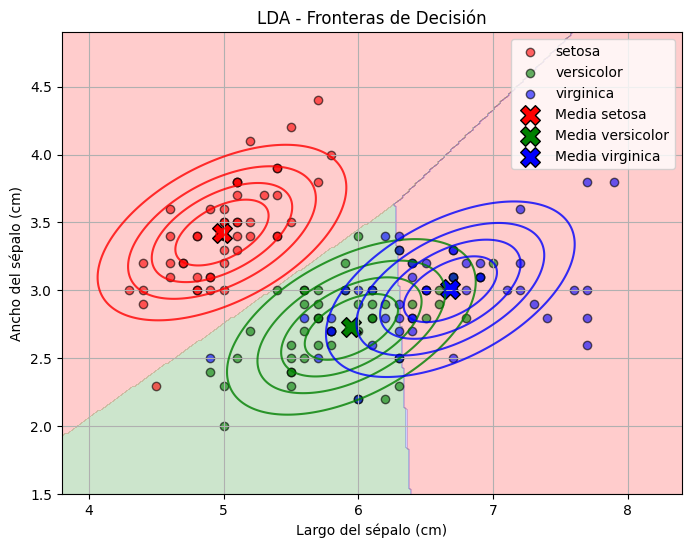

In [69]:
# === Frontera de decisión ===

# Generar grilla
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predecir clase para cada punto de la grilla
Z = lda.predict(grid)
Z = Z.reshape(xx.shape)

# Dibujar regiones de decisión (relleno)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, levels=len(lda.classes_), colors=colors)

# Scatter de datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', alpha=0.6)

# Medias
for i, mean in enumerate(lda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')

    # Curvas de nivel
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Fronteras de Decisión')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Evaluar en test
y_pred = lda.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy en test: {acc * 100:.2f}%")

Accuracy en test: 75.56%


## **Síntesis**



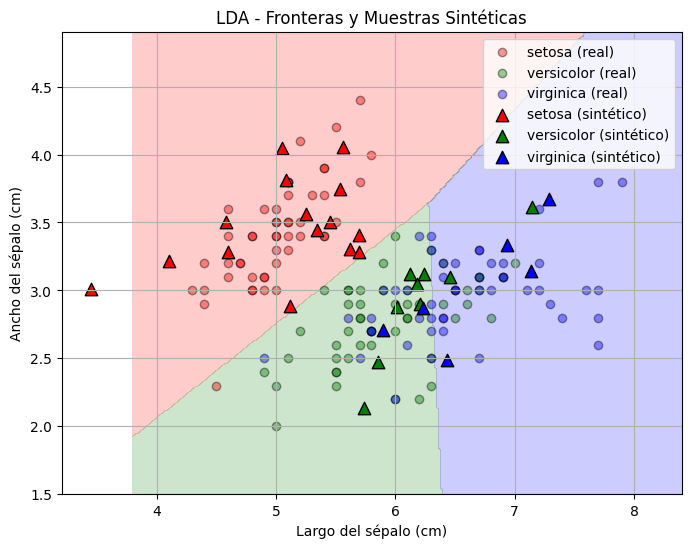

In [71]:
# === Generar 30 muestras sintéticas usando el modelo LDA ===

np.random.seed(42)  # para reproducibilidad
n_samples = 30
synthetic_X = []
synthetic_y = []

for _ in range(n_samples):
    # Elegir clase según prior
    cls = np.random.choice(lda.classes_, p=lda.priors_)
    
    # Muestrear desde la gaussiana correspondiente
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    sample = np.random.multivariate_normal(mean=lda.means_[cls], cov=cov)
    
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# === Gráfico con regiones + muestras sintéticas ===

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Scatter de datos originales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]} (real)', edgecolor='k', alpha=0.4)

# Muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]} (sintético)', edgecolor='black', s=80)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Fronteras y Muestras Sintéticas')
plt.legend()
plt.grid(True)
plt.show()


## **Discriminante Cuadrático**

Accuracy QDA en test: 71.11%


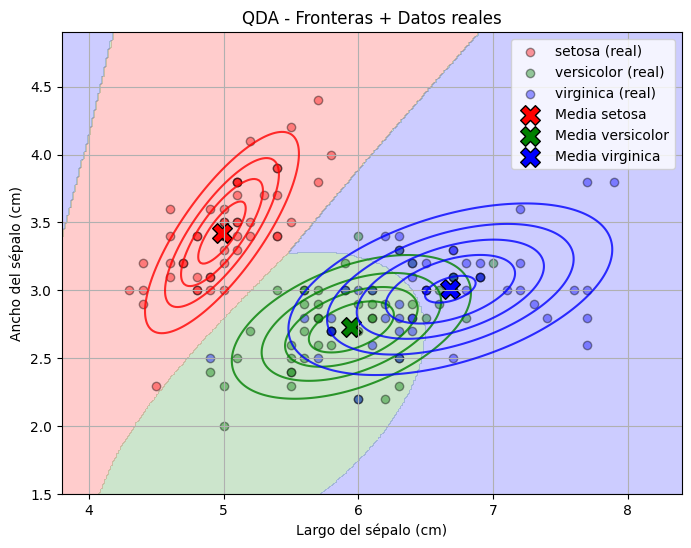

In [72]:
#entrenamos el modelo 
qda = GaussianDiscriminantAnalysis(mode='qda')
qda.fit(X_train, y_train)

# Accuracy en test
y_pred_qda = qda.predict(X_test)
acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"Accuracy QDA en test: {acc_qda * 100:.2f}%")

rv = multivariate_normal(mean=mean, cov=qda.covs_[i])  # en vez de shared_cov_


# ===== Grilla para fronteras =====
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = qda.predict(grid).reshape(xx.shape)

# ===== Gráfico 1: Datos reales =====
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]} (real)', edgecolor='k', alpha=0.4)

# Medias y gaussianas
for i, mean in enumerate(qda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'{qda.mode.upper()} - Fronteras + Datos reales')
plt.legend()
plt.grid(True)
plt.show()



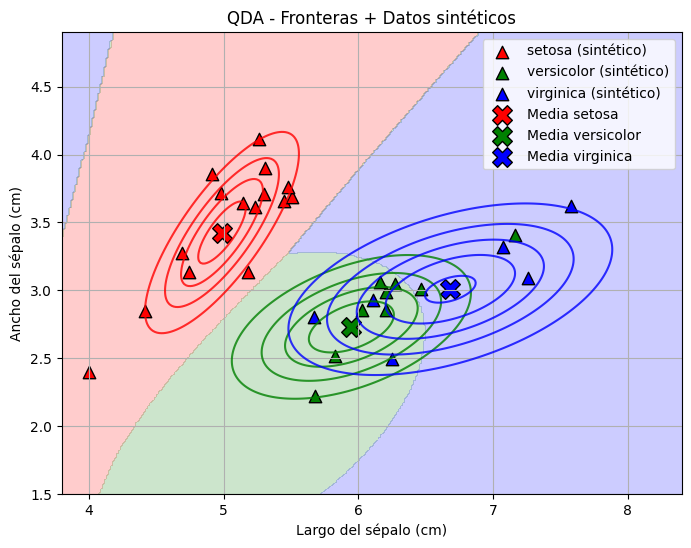

In [73]:
# ===== Generar muestras sintéticas =====
np.random.seed(42)
synthetic_X = []
synthetic_y = []
for _ in range(30):
    cls = np.random.choice(qda.classes_, p=qda.priors_)
    mean = qda.means_[cls]
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[cls]
    sample = np.random.multivariate_normal(mean, cov)
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# ===== Gráfico 2: Datos sintéticos =====
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]} (sintético)', edgecolor='black', s=80)

# Medias y gaussianas
for i, mean in enumerate(qda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'{qda.mode.upper()} - Fronteras + Datos sintéticos')
plt.legend()
plt.grid(True)
plt.show()


## **KNN**

Accuracy KNN (k=6) en test: 84.44%


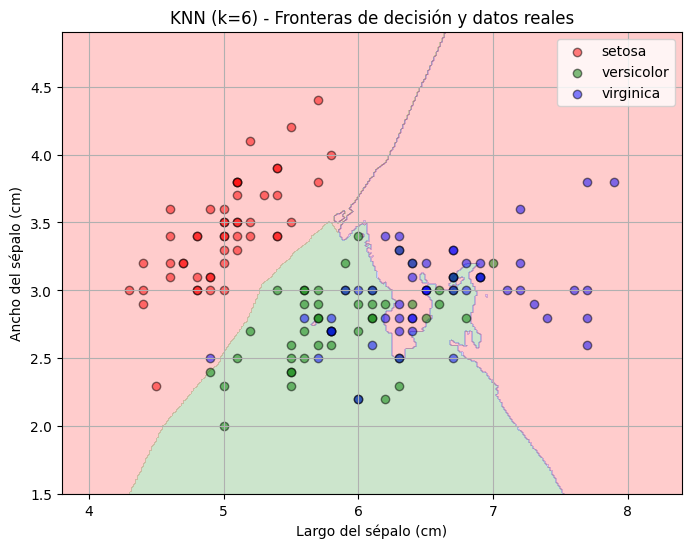

In [74]:

class KNN:
    def __init__(self, k=6):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict_proba(self, X):
        probs = []
        for x in X:
            dists = np.linalg.norm(self.X_train - x, axis=1)
            knn_indices = np.argsort(dists)[:self.k]
            knn_labels = self.y_train[knn_indices]
            counts = Counter(knn_labels)
            prob = np.array([counts.get(cls, 0) / self.k for cls in np.unique(self.y_train)])
            probs.append(prob)
        return np.array(probs)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
# Entrenar modelo
knn = KNN(k=6)
knn.fit(X_train, y_train)

# Accuracy
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy KNN (k=6) en test: {acc_knn * 100:.2f}%")

# Scatter con fronteras de decisión
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, levels=len(np.unique(y)), colors=colors)

# Datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]}', edgecolor='k', alpha=0.5)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('KNN (k=6) - Fronteras de decisión y datos reales')
plt.legend()
plt.grid(True)
plt.show()

